In [2]:
import tensorflow as tf
import numpy as np
import t3f
tf.set_random_seed(0)
np.random.seed(0)
%matplotlib inline
import matplotlib.pyplot as plt
import metric_util as mt
import data_util as du
from t3f import shapes
from nilearn import image
from tensorflow.python.util import nest
import copy
from nilearn import plotting
from t3f import ops
import mri_draw_utils as mrd
from t3f import initializers
from t3f import approximate
from scipy import optimize 
from nilearn.masking import compute_background_mask
from nilearn.masking import compute_epi_mask
from collections import OrderedDict
import pandas as pd
from scipy import stats
from nilearn.image import math_img
from t3f import initializers
import numpy.testing as nps
from dipy.sims.voxel import add_noise
import nibabel as nib

/usr/local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
subject_scan_path = du.get_full_path_subject1()
print "Subject Path: " + str(subject_scan_path)
x_true_org = mt.read_image_abs_path(subject_scan_path)
ground_truth = np.array(x_true_org.get_data()).astype('float32')
ten_ones = np.ones_like(ground_truth).astype('float32')
ten_zeros = np.zeros_like(ground_truth).astype('float32')

Subject Path: /work/pl/sch/analysis/data/COBRE001/swaAMAYER+cobre01_63001+M87100944+20110309at135133+RSTpre_V01_R01+CM.nii


In [4]:
def init_random(x):
    init = (2*np.random.random_sample(x.shape) - 1).astype('float32')
    return init

In [5]:
def cost_with_treshold(x, thresh = 0.000212633):
    res = tf.abs(t3f.full(x))
    zeros = tf.zeros_like(res)
    masked = tf.greater(res, thresh)
    new_tensor = tf.where(masked, t3f.full(x), zeros)
    return t3f.to_tt_tensor(new_tensor, max_tt_rank=63)

In [6]:
#Initialize variables

In [7]:
x_init = copy.deepcopy(ground_truth)
x_init_bk = copy.deepcopy(x_init)
norm_ground_x_init = np.linalg.norm(x_init)
x_init = x_init * (1./norm_ground_x_init)
#signal_w_noise = add_noise(x_init, 100000, 1, noise_type='rician')
#norm_ground_noise = np.linalg.norm(signal_w_noise)
#signal_w_noise = signal_w_noise * (1./norm_ground_noise)
#x_init = signal_w_noise.astype('float32')
#noise = np.random.normal(0, 1, x_init.shape)
#noisy = x_init + noise
#x_init = noisy.astype('float32')
tf_ten_zeros = t3f.to_tt_tensor(ten_zeros, max_tt_rank=63)
tf_ten_ones = t3f.to_tt_tensor(ten_ones, max_tt_rank=63)

[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [8]:
ground_truth_tf = t3f.to_tt_tensor(x_init, max_tt_rank=63)
#tf_zeros = t3f.get_variable('tf_zeros', initializer=tf_ten_zeros, trainable=False)
#tf_ones = t3f.get_variable('tf_ones', initializer=tf_ten_ones, trainable=False)
X = t3f.get_variable('X', initializer=ground_truth_tf, trainable=False)
L = t3f.get_variable('L', initializer=ground_truth_tf)
s_init = init_random(x_init)
s_init.fill(0)
s_init_tf = t3f.to_tt_tensor(s_init, max_tt_rank=63)
S = t3f.get_variable('S',initializer=s_init_tf)

#Sold = t3f.get_variable('Sold', initializer=tf_ten_zeros)
#G = t3f.get_variable('G', initializer=tf_ten_zeros)


[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]


In [9]:
print S
#Initialize Gradienst

A Tensor Train variable of shape (53, 63, 46, 144), TT-ranks: (1, 53, 63, 63, 1)


In [10]:
alpha = 0.01
mu = 0.2

gradSt3f = cost_with_treshold(X - L)
rimGradS = t3f.riemannian.project(gradSt3f,S)
#train_step_tensor_s = t3f.assign(S, gradSt3f)
train_step_tensor_s = gradSt3f
gradLt3f = 1.0/(1.0 + mu)*(X - train_step_tensor_s)
rimGradL = t3f.riemannian.project(gradLt3f,L)
train_step_tensor_l = t3f.assign(L, t3f.round(L + alpha * rimGradL, max_tt_rank=63))
low_rank_update_op = t3f.assign(S, t3f.round(X - train_step_tensor_l,  max_tt_rank=63))
normGradS = t3f.frobenius_norm(rimGradS)
normGradL = t3f.frobenius_norm(rimGradL)
total_grad = rimGradS + rimGradL
total_grad_norm = t3f.frobenius_norm(total_grad)



[1, 53, 1, 1, 1] 0 (1, 53, 53)
[1, 53, 63, 1, 1] 1 (53, 63, 63)
[1, 53, 63, 63, 1] 2 (63, 46, 63)
ranks: [1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]
Max_TT rank63
[1, 53, 63, 63, 1]


In [11]:
loss = 0.5 * t3f.frobenius_norm_squared(L + S - X)
normL_S = t3f.frobenius_norm(L + S - X)

In [12]:
def solution_stopping_criterion(ll,ss,xx):
    return (np.linalg.norm(ll + ss - xx)**2)/(np.linalg.norm(xx)**2)

In [13]:
def relative_convergence_error(solution, k):
    return np.linalg.norm(solution[k] - solution[k-1])/np.linalg.norm(solution[k-1])

In [14]:
solution_S = []
solution_L = []
solution_L_S = []

cost_S = []
cost_L = []

In [15]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [16]:
for i in range (50):
    S_val, norm_gradS_val,loss_val, L_val, norm_gradL_val, normL_S_val,total_grad_norm_val,_,_,_ = sess.run([t3f.full(S), normGradS, loss, t3f.full(L), normGradL, normL_S, total_grad_norm, train_step_tensor_s.op, train_step_tensor_l.op, low_rank_update_op.op])
    #loss_val, L_val, norm_gradL_val, normL_S_val,_ = sess.run([loss, t3f.full(L), normGradL, normL_S, train_step_tensor_l.op])
    print "Iteration#: " + str(i) + "; loss: " + str(loss_val) + "; norm_gradL: " + str(norm_gradL_val) + "; norm_gradS: " + str(norm_gradS_val)
    print "Residual Norm: " + str(normL_S_val)
    print "Gradient Norm: " + str(total_grad_norm_val)
    solution_S.append(S_val)
    solution_L.append(L_val)
    solution_L_S.append(normL_S_val)
    
    solution_tolerance = solution_stopping_criterion(L_val, S_val, x_init)
    
    if i >= 1:
        cost_s_sol = relative_convergence_error(solution_S, i)
        cost_l_sol = relative_convergence_error(solution_L, i)
        cost_ls_sol = relative_convergence_error(solution_L_S, i)
        print "S Relative Error: " + str(cost_s_sol) + "; L Relative Error: " + str(cost_l_sol)
        print "Total Solution Relative Error: " + str(cost_ls_sol)
        
    print "Solution Tolerance: " + str(solution_tolerance)
        
    

Iteration#: 0; loss: 2.7200634e-11; norm_gradL: 0.83348346; norm_gradS: 0.0031622776
Residual Norm: 0.0031622862
Gradient Norm: 0.8334858
Solution Tolerance: 8.990767438752686e-06
Iteration#: 1; loss: 1.6292691e-10; norm_gradL: 0.8334803; norm_gradS: 0.0031622776
Residual Norm: 0.003162329
Gradient Norm: 0.8334822


/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in float_scalars
  


S Relative Error: inf; L Relative Error: 0.0083334595
Total Solution Relative Error: 1.3547426e-05
Solution Tolerance: 8.990800948204528e-06
Iteration#: 2; loss: 1.7969906e-10; norm_gradL: 0.8334809; norm_gradS: 0.0031622776
Residual Norm: 0.0031623344
Gradient Norm: 0.8334822
S Relative Error: 0.99927515; L Relative Error: 0.008264381
Total Solution Relative Error: 1.6934052e-06
Solution Tolerance: 8.990802344433043e-06
Iteration#: 3; loss: 1.8493013e-10; norm_gradL: 0.8334828; norm_gradS: 0.0031622776
Residual Norm: 0.003162336
Gradient Norm: 0.8334822
S Relative Error: 0.4997863; L Relative Error: 0.008196671
Total Solution Relative Error: 5.1538336e-07
Solution Tolerance: 8.990812118035686e-06
Iteration#: 4; loss: 1.8963638e-10; norm_gradL: 0.8334808; norm_gradS: 0.0031622776
Residual Norm: 0.0031623377
Gradient Norm: 0.83348244
S Relative Error: 0.3332506; L Relative Error: 0.008129916
Total Solution Relative Error: 5.153831e-07
Solution Tolerance: 8.990820495413608e-06
Iteration#

S Relative Error: 0.03448031; L Relative Error: 0.006711257
Total Solution Relative Error: 1.1780073e-06
Solution Tolerance: 8.990842835107145e-06
Iteration#: 31; loss: 2.737946e-10; norm_gradL: 0.83348113; norm_gradS: 0.0031622776
Residual Norm: 0.0031623642
Gradient Norm: 0.83348244
S Relative Error: 0.03332889; L Relative Error: 0.006666427
Total Solution Relative Error: 1.6933836e-06
Solution Tolerance: 8.990837250181159e-06
Iteration#: 32; loss: 2.5942332e-10; norm_gradL: 0.8334808; norm_gradS: 0.0031622776
Residual Norm: 0.0031623596
Gradient Norm: 0.8334822
S Relative Error: 0.032258328; L Relative Error: 0.0066223764
Total Solution Relative Error: 1.47251e-06
Solution Tolerance: 8.990838646412493e-06
Iteration#: 33; loss: 2.1783764e-10; norm_gradL: 0.83348066; norm_gradS: 0.0031622776
Residual Norm: 0.0031623465
Gradient Norm: 0.83348215
S Relative Error: 0.0312475; L Relative Error: 0.006578881
Total Solution Relative Error: 4.123034e-06
Solution Tolerance: 8.99082608033439e-0

In [17]:
G = x_init - L_val - S_val

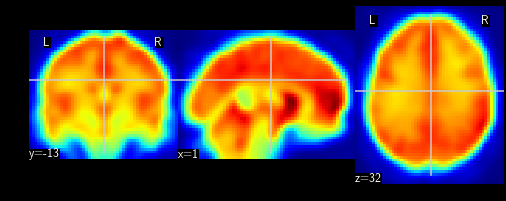

In [18]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_init)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

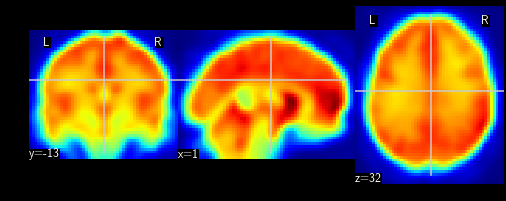

In [19]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, x_init_bk)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

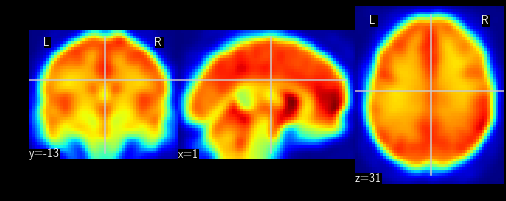

In [20]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, L_val)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [21]:
diff_img =  x_init - L_val

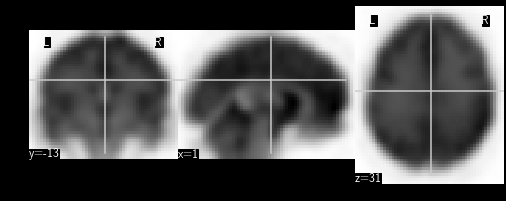

In [22]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, diff_img)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='gray', cut_coords=None)

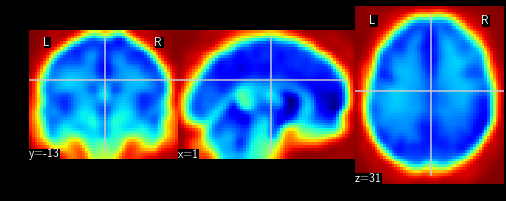

In [23]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, S_val)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

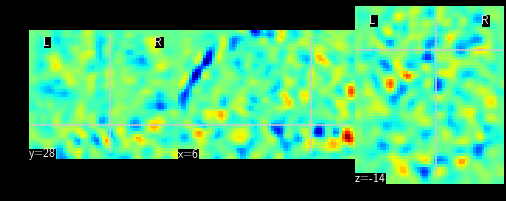

In [24]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, G)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [25]:
solution_tolerance = solution_stopping_criterion(L_val, S_val, x_init)

In [26]:
solution_tolerance

8.99086098612858e-06

In [27]:
total = S_val + L_val + G

In [28]:
nps.assert_allclose(total, x_init, rtol=1e-4, atol=0)

In [26]:
from skimage.util import random_noise

In [27]:
noisy = random_noise(x_init, var=0.01)

In [28]:
noise = np.random.normal(0, 1, x_init.shape)

In [29]:
noisy = x_init + noise

In [30]:
from dipy.sims.voxel import add_noise
from dipy.denoise.noise_estimate import estimate_sigma

In [31]:
sigma = estimate_sigma(noisy, N=1)

In [32]:
from dipy.denoise.nlmeans import nlmeans
den = nlmeans(noisy, sigma=sigma, patch_radius= 1, block_radius = 1, rician= False)

In [34]:
mask_img = compute_epi_mask(x_true_org)
mask_img_data = np.array(mask_img.get_data())

In [35]:
import noise_util

In [36]:
from dipy.sims.voxel import add_noise

In [37]:
x_init_copy = copy.deepcopy(x_init)

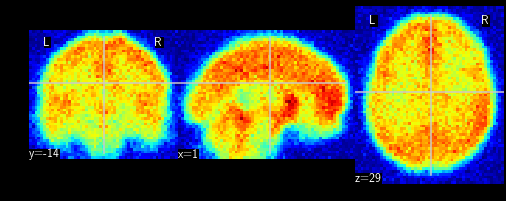

In [38]:
signal_w_noise = add_noise(x_init_copy, 100000, 1, noise_type='rician')
norm_ground_noise = np.linalg.norm(signal_w_noise)
signal_w_noise = signal_w_noise * (1./norm_ground_noise)
x_hat_img = mt.reconstruct_image_affine(x_true_org, signal_w_noise)
x_hat = image.index_img(x_hat_img,1)
recovered_image = plotting.plot_epi(x_hat, bg_img=None,black_bg=True, cmap='jet', cut_coords=None)

In [97]:
noise_img = mt.reconstruct_image_affine(x_true_org, x_init)

In [98]:
nib.save(noise_img, 'noise_img.nii')

In [54]:
#dipy.sims.voxel.add_noise(signal, snr, S0, noise_type='rician')

recovered_image = mt.reconstruct_image_affine(x_true_org, L_val)
nib.save(recovered_image, 'low-rank-img.nii')

In [55]:
from nipype.algorithms import confounds as nac

In [56]:
tsnr = nac.TSNR()
tsnr.inputs.in_file = 'low-rank-img.nii'
res = tsnr.run()
   

In [58]:
tsnr_path = 'tsnr.nii.gz'
tsnr_image = mt.read_image_abs_path(tsnr_path)
tsnr_image_data = np.array(tsnr_image.get_data())

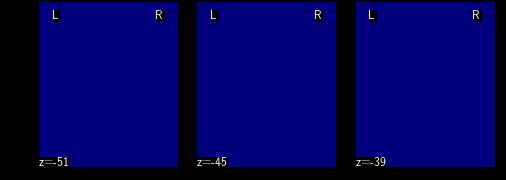

In [59]:
tsnr_img = mt.reconstruct_image_affine(x_true_org, tsnr_image_data)
recovered_image = plotting.plot_epi(tsnr_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = 3)

In [60]:
mean_path = 'mean.nii.gz'
mean_image = mt.read_image_abs_path(mean_path)
mean_image_data = np.array(mean_image.get_data())

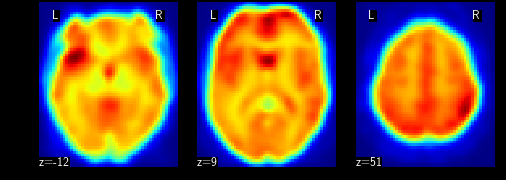

In [50]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, mean_image_data)
recovered_image = plotting.plot_epi(x_hat_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = 3)

In [61]:
stdev_path = 'stdev.nii.gz'
stdev_image = mt.read_image_abs_path(stdev_path)
stdev_image_data = np.array(stdev_image.get_data())

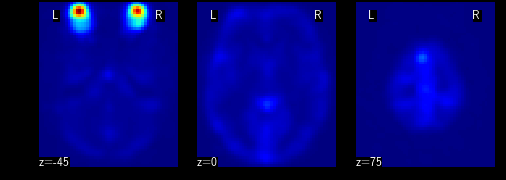

In [62]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, stdev_image_data)
recovered_image = plotting.plot_epi(x_hat_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = 3)

In [111]:
tsnr = nac.TSNR()
tsnr.inputs.in_file = subject_scan_path
res = tsnr.run()

In [112]:
stdev_path = 'stdev.nii.gz'
stdev_image = mt.read_image_abs_path(stdev_path)
stdev_image_data = np.array(stdev_image.get_data())

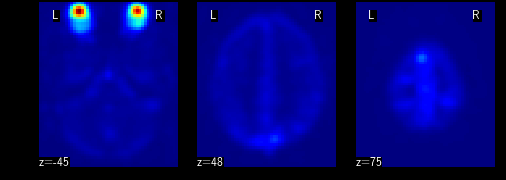

In [113]:
x_hat_img = mt.reconstruct_image_affine(x_true_org, stdev_image_data)
recovered_image = plotting.plot_epi(x_hat_img, bg_img=None,black_bg=True, display_mode='z', cmap='jet', cut_coords = 3)

In [119]:
mask_img = compute_epi_mask(x_true_org)

In [120]:
nib.save(mask_img, 'epi_mask.nii')

In [64]:
dvars = nac.ComputeDVARS()

In [135]:
dvars.inputs.in_file = subject_scan_path
dvars.inputs.in_mask = 'epi_mask.nii'
dvars.inputs.save_all = True
dvars.inputs.save_plot = True
dvars.inputs.figformat = 'pdf'
dvars.run()

In [65]:
dvars.inputs.in_file = 'low-rank-img.nii'
dvars.inputs.in_mask = 'epi_mask.nii'
dvars.inputs.save_all = True
dvars.inputs.save_plot = True
dvars.inputs.figformat = 'pdf'
dvars.run()

/usr/local/lib/python2.7/site-packages/nitime/utils.py:980: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, np.complex) or
/usr/local/lib/python2.7/site-packages/nitime/utils.py:981: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, np.complex))


In [134]:
comp_corr = nac.CompCor()
comp_corr.inputs.realigned_file = subject_scan_path
comp_corr.run()